In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow_addons as tfa
import os
import pandas as pd

In [3]:
train_datagen= ImageDataGenerator(
                                rescale=1./255, 
                                rotation_range = 90,
                                horizontal_flip = True,
                                vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        './Data/train',
        target_size=(150, 150),
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './Data/val',
        target_size=(150, 150),
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [4]:
base_model = tf.keras.applications.EfficientNetB5(
    include_top=False, 
    weights='imagenet',
    input_shape= (150,150,3)
)

In [5]:
base_model.trainable = True

In [6]:
inputs = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.concatenate([inputs,inputs,inputs], axis = -1)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [2]:
from tensorflow_addons.optimizers import CyclicalLearningRate
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=1e-6,
 maximal_learning_rate=1e-3,
 step_size=938*6,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=cyclical_learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
    loss='CategoricalCrossentropy',
    metrics=[tf.keras.metrics.AUC(name = "auc"), tf.keras.metrics.CategoricalAccuracy()]
)

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./cp_{epoch}_.ckpt",
    monitor='val_auc',
    verbose=1,
    save_weights_only=True,
    mode='auto',
    save_freq = 1000
)

In [10]:
lr_red = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.000001
)

In [11]:
history =model.fit(
        train_generator,
        steps_per_epoch = 938,
        validation_steps = 200,
        epochs = 50,
        verbose = 2,
        validation_data=validation_generator,
        callbacks = [checkpoint]
    
)

2022-04-10 12:12:53.688738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-10 12:13:13.561215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


938/938 - 396s - loss: 1.0024 - auc: 0.6671 - categorical_accuracy: 0.4641 - val_loss: 0.7180 - val_auc: 0.8572 - val_categorical_accuracy: 0.6830
Epoch 2/50

Epoch 00002: saving model to ./cp_2_.ckpt
938/938 - 356s - loss: 0.5406 - auc: 0.9218 - categorical_accuracy: 0.7827 - val_loss: 0.4647 - val_auc: 0.9425 - val_categorical_accuracy: 0.8184
Epoch 3/50

Epoch 00003: saving model to ./cp_3_.ckpt
938/938 - 356s - loss: 0.3954 - auc: 0.9581 - categorical_accuracy: 0.8518 - val_loss: 0.4216 - val_auc: 0.9560 - val_categorical_accuracy: 0.8533
Epoch 4/50

Epoch 00004: saving model to ./cp_4_.ckpt
938/938 - 355s - loss: 0.3596 - auc: 0.9649 - categorical_accuracy: 0.8691 - val_loss: 0.3645 - val_auc: 0.9651 - val_categorical_accuracy: 0.8698
Epoch 5/50

Epoch 00005: saving model to ./cp_5_.ckpt
938/938 - 354s - loss: 0.3354 - auc: 0.9695 - categorical_accuracy: 0.8801 - val_loss: 0.3361 - val_auc: 0.9699 - val_categorical_accuracy: 0.8692
Epoch 6/50

Epoch 00006: saving model to ./cp_6_.

In [12]:

pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

In [9]:
model.load_weights("cp_38_.ckpt")

In [11]:
model.evaluate(validation_generator)

235/235 [==============================] - 52s 184ms/step - loss: 0.1162 - auc: 0.9954 - categorical_accuracy: 0.9597


[0.11619173735380173, 0.9954259395599365, 0.9597333073616028]

In [3]:
df = pd.read_csv("history.csv")

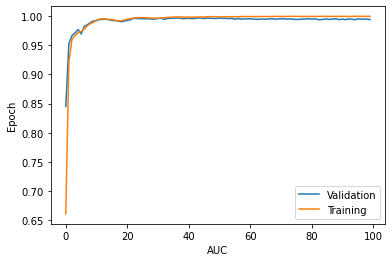

In [4]:
plt.plot(np.array(range(0,100)), np.array(df["val_auc"]), label = "Validation" )
plt.plot(np.array(range(0,100)), np.array(df["auc"]) , label = "Training" )
plt.xlabel("AUC")
plt.ylabel("Epoch")
plt.legend()
plt.show()
#Validation_auc

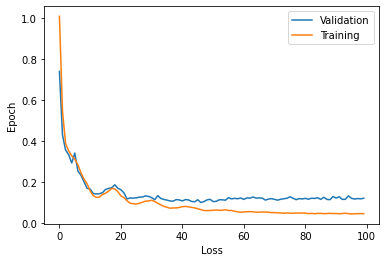

In [5]:
plt.plot(np.array(range(0,100)), np.array(df["val_loss"]), label = "Validation" )
plt.plot(np.array(range(0,100)), np.array(df["loss"]) , label = "Training" )
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()
plt.show()
#Validation_auc

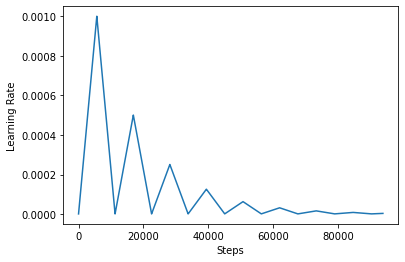

In [15]:
step = np.arange(0, 100 * 938)
lr = cyclical_learning_rate(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()
#Learning Rate

In [17]:
model.save("Common" , save_format="hd5")

INFO:tensorflow:Assets written to: Common\assets


C:\Users\cdipt\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\cdipt\AppData\Roaming\Python\Python38\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
